<a href="https://colab.research.google.com/github/MAGOUJOUGRACE/public/blob/master/Pricing_American_Options.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Pricing Bermudan put option using Monte Carlo simulation and the Longstaff-Schwartz algorithm

### Conditional expectation approach by regression

The code below is used to price a Bermudan put option using Monte Carlo simulation and the Longstaff-Schwartz algorithm.
The input parameters for the function **Bermudean_Put_MC_LS()** are:

*   the risk-free rate **r**,
*   the initial stock price **S0**,
*   the volatility **sigma**,
*   the time to maturity **T**,
*   the strike price **K**,
*   the number of Monte Carlo scenarios **N**,
*   the number of time steps **n**, and
*   the basis size **basis_size**

The function begins by generating a matrix of normal random variables using **npr.normal()** function from NumPy. These random variables are used to generate log returns for the stock price, which is then transformed into stock price paths using the Black-Scholes model.

The **Longstaff-Schwartz algorithm** is then applied to these stock price paths to calculate the optimal exercise time for each path. This is done by iterating backwards through the time steps, starting from the maturity date and working backwards. For each time step, a regression is performed to estimate the continuation value of the option. If the intrinsic value (the difference between the strike price and the stock price) is greater than the continuation value, the option is exercised; otherwise, it is not.

The function returns the Bermudan put price, the upper and lower bounds of the 95% confidence interval, the error, and the exercise time for the optimal exercise strategy. The exercise time is plotted on a graph using Matplotlib's plt.plot() function.

In [ ]:
import numpy as np   # math operations
import numpy.random as npr # random
import matplotlib.pyplot as plt # plot
import time
from scipy import linalg


[2.311034595943795, 2.3279965107290086, 2.2940726811585814, 0.016961914785213597]
[49.68668, 49.38508, 49.0779, 48.78959, 48.50291, 48.20182, 47.91924, 47.66167, 47.36267, 47.09598, 46.83123, 46.58392, 46.3474, 46.08676, 45.85825, 45.62973, 45.37807, 45.18149, 44.91032, 44.70007, 44.48949, 44.29886, 44.05459, 43.8145, 43.63649, 43.42554, 43.25169, 43.03637, 42.82952, 42.67224, 42.50876, 42.32686, 42.21468, 42.03038, 41.88373, 41.71348, 41.56463, 41.41974, 41.26173, 41.17262, 41.13637, 41.08897, 41.06434, 41.01028, 40.96254, 40.93236, 40.92032, 40.92032, 40.92032, 40.92032]


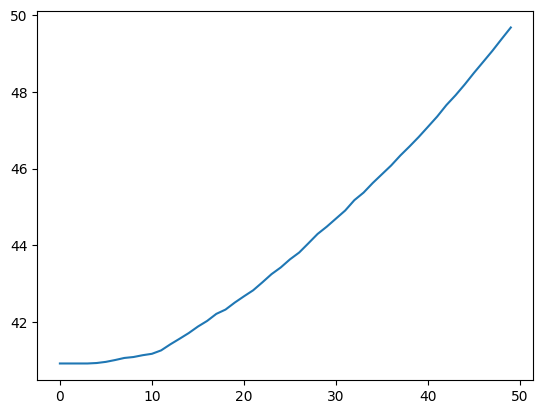

In [ ]:
def Bermudean_Put_MC_LS(r,S0,sigma,T,K,N,n, basis_size):

    dt=float(T/n)

    G=npr.normal(0,1,size=(N,n))

    #Log returns
    LR=(r-0.5*sigma**2)*dt+np.sqrt(dt)*sigma*G
    # concatenate with log(S0)
    LR=np.concatenate((np.log(S0)*np.ones((N,1)),LR),axis=1)
    # cumsum horizontally (axis=1)
    LR=np.cumsum(LR,axis=1)
    # take the expo Spath matrix
    Spaths=np.exp(LR)
    #print(Spaths)

    # Longstaff & Schwartz

    #discount rates over different time intervals

    discountVect = np.exp(-r*dt*np.arange(1, n+1, 1))


    #generate sample paths



    CashFlows = np.maximum(0, K-Spaths[:,- 1]) # all scenarios of the payoff max(K-ST,0) at maturity


    # N : MONTE CARLO SCENARIOS
    ExerciseTime = n* np.ones(N)
    ExerciseTime = ExerciseTime.astype('int')

    Tau=[] # Continuation value average

    for step in range(n-1, -1, -1): #backward for loop

        Time_to_maturity=n* np.ones(N)-step

        index_in_money = np.argwhere(Spaths[:, step] < K)

        X = Spaths[index_in_money, step]  # X= S_{t_k} t_k is the step where I am in the for loop

        #np.ones((X.shape[0],1))
        Reg_list=[]

        for degree in range(basis_size):
            Reg_list.append(X**degree)

        RegrMat = np.array(Reg_list) #(1, Stk, Stk^2, Stk^3, Stk^4) basis of size 5

        YData = CashFlows[index_in_money]*discountVect[ExerciseTime[index_in_money] - step-1]


        a = linalg.lstsq(np.squeeze(RegrMat.T),YData)[0] # finding the regressors
        IntrinsicValue =  K-X;
        ContinuationValue = np.dot(np.squeeze(RegrMat.T), a) #approximation for the conditional expectation



        index_Exercise=np.argwhere(IntrinsicValue  > ContinuationValue)

        k = index_in_money[index_Exercise]

        CashFlows[k] = IntrinsicValue[index_Exercise];
        ExerciseTime[k] = step
        Tau.append(np.mean(ExerciseTime))


    payoff= CashFlows*discountVect[ExerciseTime-1]
    Bermudean_MC_price=np.mean(payoff)

    # 95% C.I

    STD=np.std(payoff) # standard deviation estimator

    error=1.96*STD/np.sqrt(N)

    CI_up=Bermudean_MC_price + error
    CI_down=Bermudean_MC_price -error

    return Bermudean_MC_price,CI_up,CI_down,error,Tau

start_time_ls = time.time()

[Bermudean_MC_price,CI_up,CI_down,error,Tau]=Bermudean_Put_MC_LS(0.06,40,0.2,1,40,100000,50,5)

end_time_ls = time.time()




print([Bermudean_MC_price,CI_up,CI_down,error])

# Frontier exercice
print(Tau)

plt.plot(Tau[::-1])



### Approach using a deep neural network

For the approach using a deep neural network to approximate the conditional expectation, we will follow these steps

**Step 1:**  We would need to generate the sample paths of the underlying asset using the same process as in the **Longstaff-Schwartz algorithm**. This would involve simulating a large number of scenarios using the **Black-Scholes model** with **Monte Carlo simulations**.

**Step 2:** Calculating of the payoff for each scenario at each exercise time.

**Step 3:** Implementing of  a deep neural network that takes in the current stock price and the time remaining until the next exercise time as inputs, and outputs an estimate of the expected payoff at the next exercise time. we would train the network using the payoff values from step 2 as the target variable.

**Step 4:** At each exercise time, evaluating the neural network on the in-the-money scenarios and comparing the estimated payoff to the intrinsic payoff. If the intrinsic payoff is greater, the option would be exercised, and the corresponding cash flows would be updated. If not, the option would continue to be held.

**Step 5:** you would discount the resulting cash flows back to the present to obtain the Bermudean put option price.

#### Import libraries




In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, ReLU, Activation, Flatten
from keras.constraints import non_neg
from keras.callbacks import EarlyStopping

#### Set the parameters and initialize variables:

In [ ]:
S0=40  # Initial asset price
sigma = 0.2  # Volatility
r=0.06  # Risk-free interest rate
T = 1  # Time to expiration
K=40  # Strike price
N = 100000  # Number of Monte Carlo paths
n = 50 # Number of time steps
input_dim = n  # Number of input features
n_nn = 100000 # for the data of the neural network

#### Generate the Monte Carlo paths under the Black-Scholes model




In [ ]:
def BS_model_path(S0,r,sigma,T,n):

    # S0 spot price
    # r instantenous interest rate
    # sigma volatility
    # T maturity
    # n number of time steps
    dt=T/n # time step
    Log_returns=(r-sigma**2/2)*dt + sigma*np.sqrt(dt)*npr.normal(0,1,size=(n,1))# brownian increments
    Log_path=np.cumsum(np.concatenate((np.log(S0)*np.ones((1,1)),Log_returns)))  # concatenate with S0
    S= np.exp(Log_path)
    t=np.linspace(0,T,n+1)

    return t,S

#### compute a deep neural network to approximate the conditional expectation appearing in the continuation condition:

Here we want to approximate $$ \mathbb{E}^*[\exp(-rx)(K-y)_+|y]$$ using neural network.

Where x represente the time step size between two dates and y the path.

In [ ]:
start_time_nn = time.time()
model = Sequential()
model.add(Input(shape=(1,)))
model.add(Dense(32,  activation='relu'))
model.add(Dense(16,  activation='relu'))
model.add(Dense(1 ,activation='relu', kernel_constraint=non_neg()))
callbacks = EarlyStopping(monitor='val_loss',patience=15)
model.compile(loss='mse',optimizer=tf.optimizers.Adam(learning_rate=0.001))

# Generate training data
X_train = np.random.uniform(0.01, 1, n_nn+1)
Y_train = BS_model_path(S0,r,sigma,T,n_nn)[1]


history = model.fit(Y_train, np.exp(-r*X_train)*np.maximum(0,K-Y_train), batch_size=64, epochs=100, callbacks=[callbacks], validation_split=0.2, verbose=2)

Epoch 1/100
1250/1250 - 4s - loss: 4.3696 - val_loss: 5.9676 - 4s/epoch - 3ms/step
Epoch 2/100
1250/1250 - 2s - loss: 3.2979 - val_loss: 0.6396 - 2s/epoch - 2ms/step
Epoch 3/100
1250/1250 - 3s - loss: 0.8530 - val_loss: 0.1811 - 3s/epoch - 2ms/step
Epoch 4/100
1250/1250 - 4s - loss: 0.0643 - val_loss: 0.0039 - 4s/epoch - 3ms/step
Epoch 5/100
1250/1250 - 4s - loss: 0.0039 - val_loss: 2.5618e-06 - 4s/epoch - 3ms/step
Epoch 6/100
1250/1250 - 5s - loss: 0.0045 - val_loss: 2.3629e-08 - 5s/epoch - 4ms/step
Epoch 7/100
1250/1250 - 5s - loss: 0.0048 - val_loss: 9.7790e-07 - 5s/epoch - 4ms/step
Epoch 8/100
1250/1250 - 3s - loss: 0.0046 - val_loss: 4.9868e-07 - 3s/epoch - 2ms/step
Epoch 9/100
1250/1250 - 2s - loss: 0.0045 - val_loss: 1.7002e-06 - 2s/epoch - 2ms/step
Epoch 10/100
1250/1250 - 2s - loss: 0.0044 - val_loss: 3.1793e-07 - 2s/epoch - 2ms/step
Epoch 11/100
1250/1250 - 3s - loss: 0.0048 - val_loss: 2.4093e-07 - 3s/epoch - 2ms/step
Epoch 12/100
1250/1250 - 3s - loss: 0.0049 - val_loss: 3.

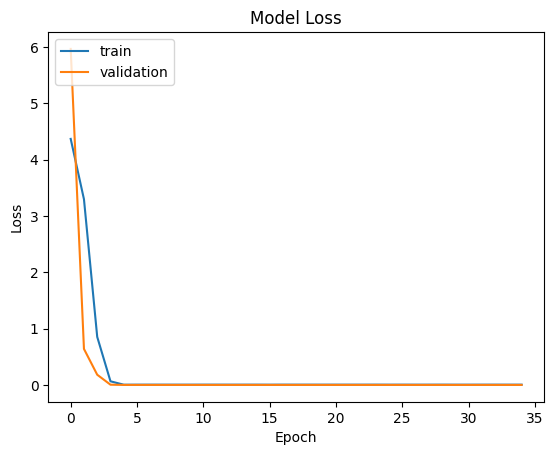

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','validation'],loc= 'upper left')
plt.show()

#### Perform the backward induction step of the Longstaff-Schwarz algorithm with a deep neural network.

In [ ]:
def backward(N,n,Spaths,K, model):
  CashFlows = np.maximum(0, K-Spaths[:,- 1]) # all scenarios of the payoff max(K-ST,0) at maturity
    # N : MONTE CARLO SCENARIOS
  ExerciseTime = n* np.ones(N)
  ExerciseTime = ExerciseTime.astype('int')

  Tau=[] # Continuation value average
  for step in range(n-1, 0, -1):#backward for loop
    Time_to_maturity= n* np.ones(N)-step
    index_in_money = np.argwhere(Spaths[:, step] < K)
    X = Spaths[index_in_money, step]  # X= S_{t_k} t_k is the step where I am in the for loop
    IntrinsicValue =  K-X
    ContinuationValue = model.predict(X)
    index_Exercise=np.argwhere(IntrinsicValue  > ContinuationValue)
    k = index_in_money[index_Exercise]
    CashFlows[k] = IntrinsicValue[index_Exercise]
    ExerciseTime[k] = step
    Tau.append(np.mean(ExerciseTime))

  return  CashFlows, ExerciseTime, Tau

In [ ]:
def calculate_option_price(ExerciseTime, N, n, CashFlows):
  dt=float(T/n)
  #discount rates over different time intervals
  discountVect = np.exp(-r*dt*np.arange(1, n+1, 1))
  payoff= CashFlows*discountVect[ExerciseTime-1]
  Bermudean_MC_price=np.mean(payoff)

    # 95% C.I

  STD=np.std(payoff) # standard deviation estimator

  error=1.96*STD/np.sqrt(N)

  CI_up=Bermudean_MC_price + error
  CI_down=Bermudean_MC_price - error

  return Bermudean_MC_price,CI_up,CI_down,error

In [ ]:
#generate sample paths
spaths = np.zeros((N,n+1))
for i in range(N):
  spaths[i,:] = BS_model_path(S0,r,sigma,T,n = n)[1]


In [ ]:
#start_time_nn = time.time()
CashFlows, ExerciseTime, Tau = backward(N,n,spaths,K, model)
Bermudean_MC_price,CI_up,CI_down,error = calculate_option_price(ExerciseTime, N, n, CashFlows)
end_time_nn = time.time()

1530/1530 [==============================] - 2s 1ms/step


In [ ]:
print ([Bermudean_MC_price,CI_up,CI_down])

[0.7083210860467994, 0.7122510200468397, 0.7043911520467592]


### Compare its efficiency with the above Longstaff Schwarz algorithm.

In [ ]:
computation_time_nn = end_time_nn - start_time_nn
computation_time_ls = end_time_ls - start_time_ls

In [ ]:
print("Computation time (Longstaff-Schwarz):", computation_time_ls, "seconds")
print("Computation time (Neural Network):", computation_time_nn, "seconds")

Computation time (Longstaff-Schwarz): 5.055227041244507 seconds
Computation time (Neural Network): 289.7653000354767 seconds


It can be difficult to compare the effectiveness of the Longstaff-Schwarz algorithm with a deep neural network approximation since it depends on a number of variables, including the complexity of the option, the amount of time steps, the quantity of Monte Carlo routes, and the neural network's architecture.

For pricing Bermudan options, the Longstaff-Schwarz algorithm has been extensively utilized and shown to be successful. It uses regression techniques to approximate the conditional expectation, which makes it versatile and efficient in terms of computing.

A deep neural network, on the other hand, adds more complexity and computing overhead when used to estimate the conditional expectation. Iterations of the optimization process are necessary during the neural network training process, and these can be time-consuming, particularly for large datasets or sophisticated topologies.

For pricing Bermudan options, the Longstaff-Schwarz algorithm typically performs more efficiently than a deep neural network. The approach is ideal for real-world applications because its computing cost is mostly determined by the quantity of time steps and Monte Carlo routes.

It's important to keep in mind, nevertheless, that a deep neural network approximation might provide greater adaptability and precision in capturing complicated option payoffs and pricing dynamics. An alternative to the regression-based Longstaff-Schwarz algorithm may be a neural network if the choice has complex properties or displays non-linear behavior.

The Longstaff-Schwarz algorithm or a neural network approximation should be chosen based on the problem's specific needs, such as  speed, processing resources, and the kind of the option being priced. To make an informed choice, it is advised to test both strategies and evaluate their effectiveness in your particular situation.





